In [1]:
%load_ext autoreload
%autoreload 2
from loguru import logger
import sys

In [2]:
logger.remove()
logger.add(sys.stderr, level="INFO")

1

In [3]:
from evaluation_utils import ClevrEvaluator
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

In [ ]:
folder = "results"
ground_truth_folder = "data"
llms = ["gpt-4o-mini", "gpt-4o", "Meta-Llama-3.1-8B-Instruct", "Meta-Llama-3.1-70B-Instruct"]
llm_labels = [
    "gpt-4o-mini", "gpt-4o", "Llama3.1-8b", "Llama3.1-70b"
]

dataset = "clevr"
num_generations = range(1, 11)
ground_truth_path = f"{ground_truth_folder}/{dataset}.csv"

In [12]:
llm_results = {}
for llm in llms:
    results = {"con": [], "incon": []}
    folder_path = f"{folder}/{llm}"
    for num_generation in tqdm(num_generations):
        evaluator = ClevrEvaluator(
            folder_path,
            dataset,
        )

        df = pd.read_csv(f"{folder_path}/{dataset}/results_{num_generation}.csv")[
            "0"
        ].tolist()
        evaluation_results = evaluator.evaluate_solutions(df, return_value="all")
        num_samples = len(evaluation_results["accuracy"])
        accuracy_con = np.mean(
            [
                evaluation_results["accuracy"][i]
                for i in range(num_samples)
                if evaluation_results["success_rate"][i] == 1
            ]
        )
        accuracy_incon = np.mean(
            [
                evaluation_results["accuracy"][i]
                for i in range(num_samples)
                if evaluation_results["success_rate"][i] == 0
            ]
        )

        results["con"].append(accuracy_con)
        results["incon"].append(accuracy_incon)

        # results.extend(
        #     [
        #         {"accuracy": accuracy, "success_rate": success_rate}
        #         for (accuracy, success_rate) in zip(
        #             evaluation_results["accuracy"],
        #             evaluation_results["success_rate"],
        #         )
        #     ]
        # )
    llm_results[llm] = results

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
num_generation = 10
abscon_result = {}
for llm in tqdm(llms):
    results = {
        "abscon": [] 
    }
    folder_path = f"{folder}/{llm}"
    evaluator = ClevrEvaluator(
            folder_path,
            dataset,
    )
    df = pd.read_csv(f"{folder_path}/{dataset}/results_abscon_{num_generation}.csv")[
        "0"
    ].tolist()
    evaluation_results = evaluator.evaluate_solutions(df, return_value="mean")

    results["abscon"].append(evaluation_results["accuracy"])
        # results.extend(
        #     [
        #         {"accuracy": accuracy, "success_rate": success_rate}
        #         for (accuracy, success_rate) in zip(
        #             evaluation_results["accuracy"],
        #             evaluation_results["success_rate"],
        #         )
        #     ]
        # )
    abscon_result[llm] = results

  0%|          | 0/4 [00:00<?, ?it/s]

In [13]:
llm_results[llm]

{'con': [0.9269406392694064,
  0.9323671497584541,
  0.9045454545454545,
  0.9134615384615384,
  0.9074074074074074,
  0.9174311926605505,
  0.9220183486238532,
  0.9247787610619469,
  0.9035087719298246,
  0.9198113207547169],
 'incon': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}

In [15]:
## Plot the difference between consistent and non-consistent candidates
llm_results_categorization = {
    "abscon": [],
    "consistent": [],
    "inconsistent": []
}

for llm in llms:
    results = llm_results[llm]
    llm_results_categorization["abscon"].append(abscon_result[llm]["abscon"])
    llm_results_categorization["consistent"].append(llm_results[llm]["con"])
    llm_results_categorization["inconsistent"].append(llm_results[llm]["incon"])


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
plt.style.use(['science', "ieee"])


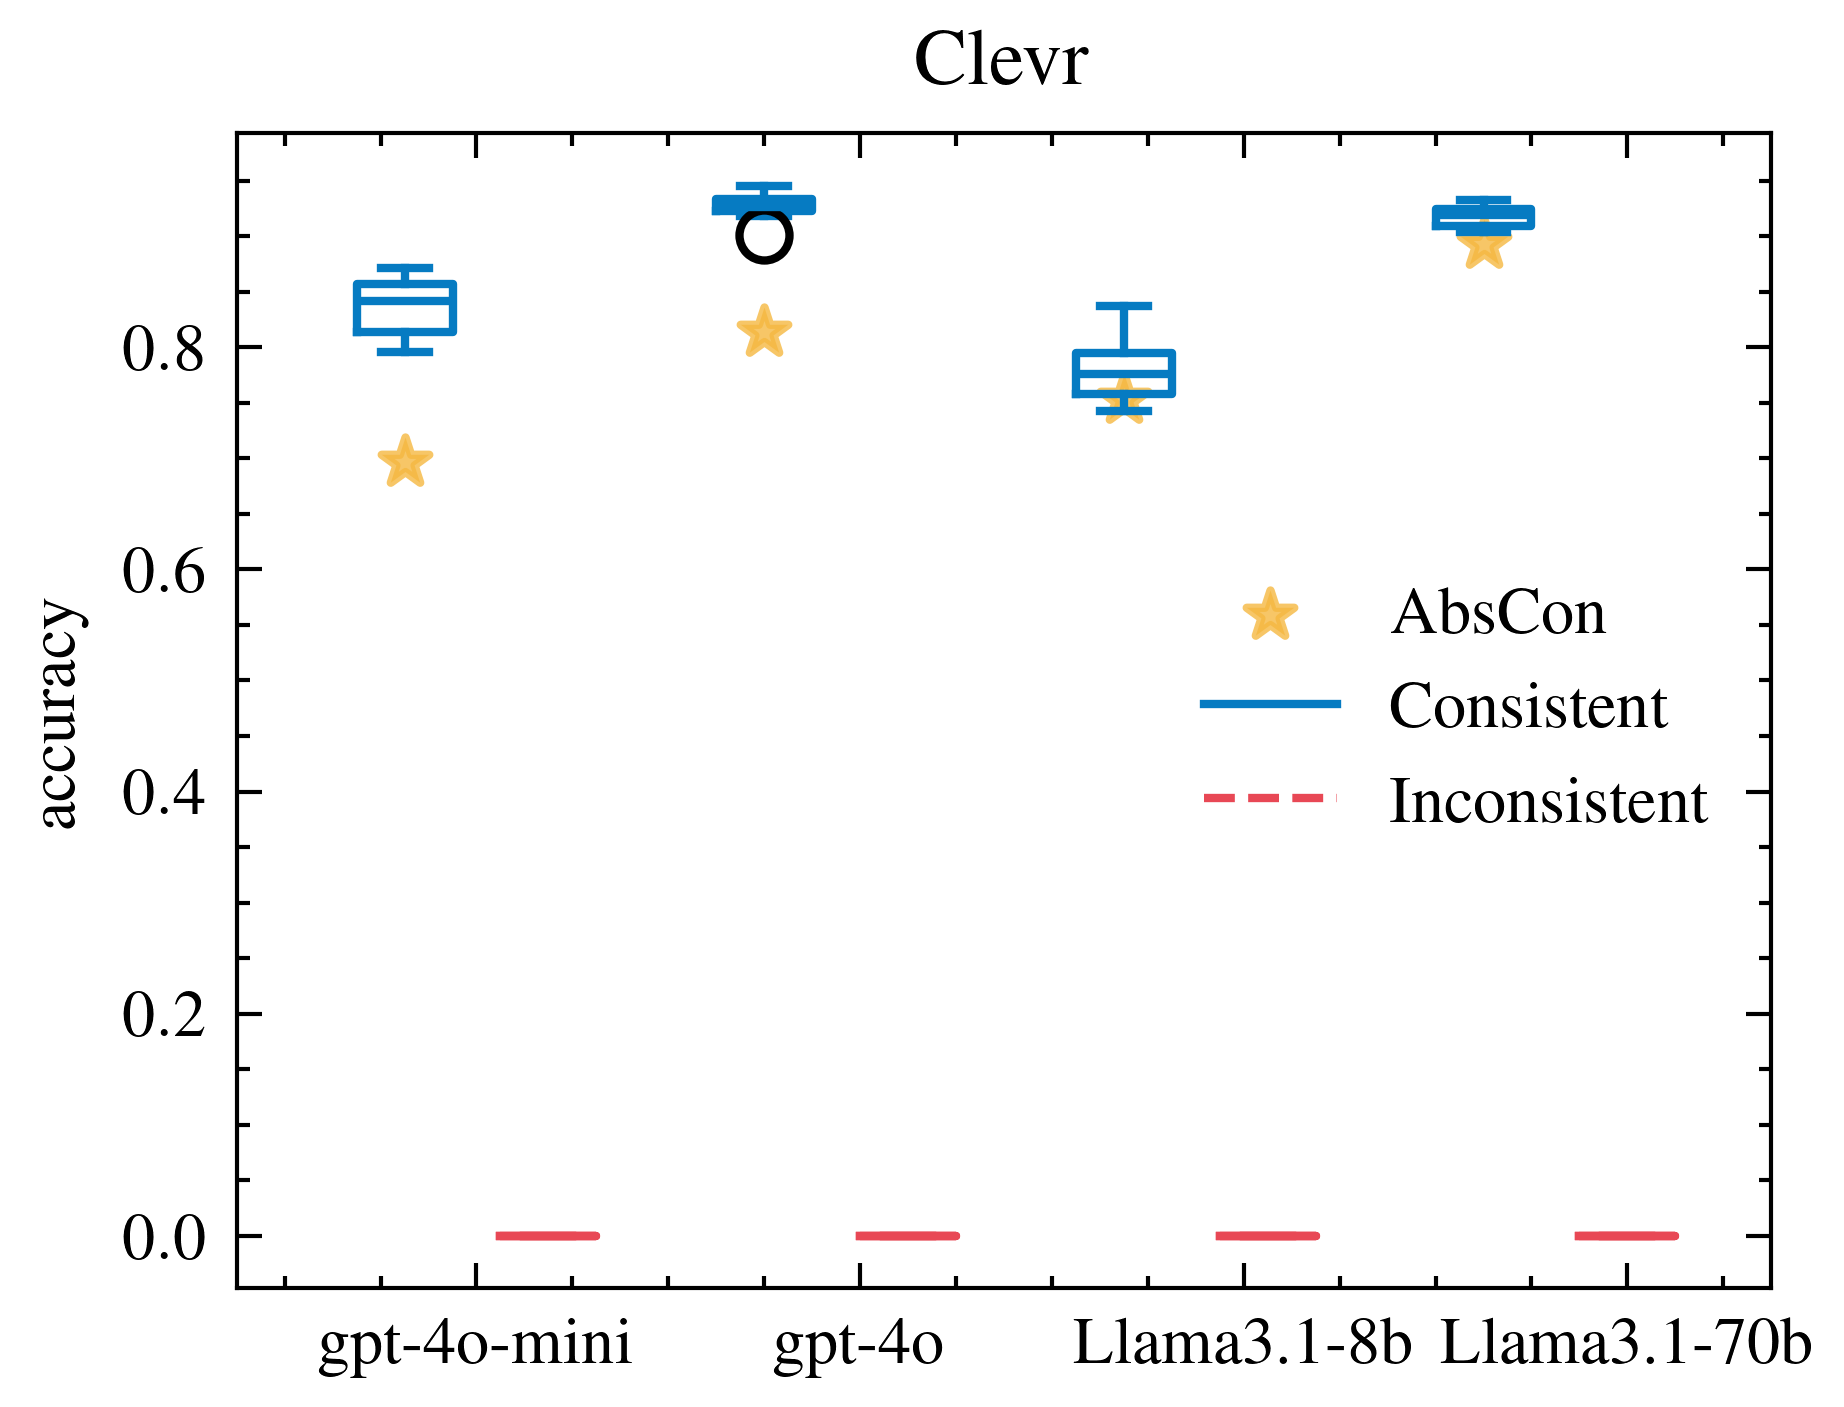

In [27]:
abscon_results = llm_results_categorization["abscon"]
# abscon_plot = plt.boxplot(abscon_results,
#                                positions=np.array(
#     np.arange(len(abscon_results)))*3.0-0.8,
#                                widths=0.8)

for i, abscon_result in enumerate(abscon_results):
    abscon_plot = plt.scatter(
        i * 3.0 - 0.6,
        abscon_results[i],
        alpha=0.8,
        label="AbsCon" if i == 0 else None,
        marker="*",
        color="#F5B841",
    )
consistent_results = llm_results_categorization["consistent"]
consistent_plot = plt.boxplot(
    consistent_results,
    positions=np.array(np.arange(len(consistent_results))) * 3.0 - 0.6,
    widths=0.8,
)

inconsistent_results = llm_results_categorization["inconsistent"]
inconsistent_plot = plt.boxplot(
    inconsistent_results,
    positions=np.array(np.arange(len(inconsistent_results))) * 3.0 + 0.6,
    widths=0.8,
)


def define_box_properties(plot_name, color_code, label):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)

    # use plot function to draw a small line to name the legend.
    plt.plot([], c=color_code, label=label)
    plt.legend()
plt.legend()

# setting colors for each groups
# define_box_properties(abscon_plot, '#F5B841', 'AbsCon')
define_box_properties(consistent_plot, "#067BC2", "Consistent")
define_box_properties(inconsistent_plot, "#E84855", "Inconsistent")

plt.xticks(np.arange(0, len(llm_labels) * 3.2, 3.2), llm_labels)
plt.xlim(-2, len(llm_labels) * 2.7)

plt.ylabel("accuracy")
plt.title("Clevr")
plt.savefig(f"Clevr.png", dpi=300)
plt.show()

In [25]:
from cliffs_delta import cliffs_delta, lookup_size
from scipy.stats import ranksums

In [19]:
statistical_test_results = []
for consistent_result, inconsistent_result in zip(consistent_results, inconsistent_results):
    statistical_test_results.append(ranksums(consistent_result, inconsistent_result, alternative="greater"))


In [20]:
statistical_test_results

[RanksumsResult(statistic=3.779644730092272, pvalue=7.852614211537559e-05),
 RanksumsResult(statistic=3.779644730092272, pvalue=7.852614211537559e-05),
 RanksumsResult(statistic=3.779644730092272, pvalue=7.852614211537559e-05),
 RanksumsResult(statistic=3.779644730092272, pvalue=7.852614211537559e-05)]

In [21]:
dull = {'small': 0.147, 'medium': 0.33, 'large': 0.474} # effect sizes from (Hess and Kromrey, 2004)

In [22]:
cliffs_values = []
for consistent_result, inconsistent_result in zip(consistent_results, inconsistent_results):
    cliffs_values.append(cliffs_delta(consistent_result, inconsistent_result)[0])
mean_cliff = np.mean(cliffs_values)

In [23]:
mean_cliff

1.0

In [24]:
lookup_size(mean_cliff, dull)

'large'